In [1]:
#import pygmt
#import pyshtools as pysh
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import stripy
from gprm.utils.raster import write_xyz_file
import ptt.utils.call_system_command as call_system_command


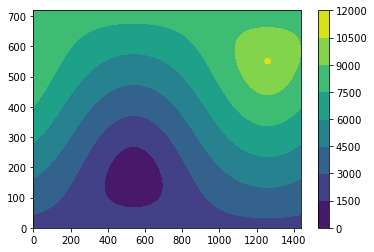

10669.445
10649.999095669398


In [5]:
crater_name = 'Argyre'

if crater_name=='Hellas':
    CraterDistance = xr.open_dataarray('DistanceToHellasCentre.nc')
    inner_limit = 500.
    outer_limit = 2000.
    
elif crater_name=='Argyre':
    CraterDistance = xr.open_dataarray('DistanceToArgyreCentre.nc')
    inner_limit = 500.
    outer_limit = 1800.
    
elif crater_name=='Isidis':
    CraterDistance = xr.open_dataarray('DistanceToIsidisCentre.nc')
    inner_limit = 500.
    outer_limit = 1500.
    
    
plt.contourf(CraterDistance.data)
plt.colorbar()
plt.show()

print(CraterDistance.data.max())
print(3390*np.pi)


lons,lats = np.meshgrid(CraterDistance.lon.data, CraterDistance.lat.data)


In [6]:
# generic function to interpolate nans, based on a raster where the 
# there is a mixture of nans and real numbers
# values are only interpolated at the nodes specified
# by 'ind_hole', then mapped back into the raster
def interpolate_hole(lons, lats, ramping, ind_hole, method='stripy'):

    if method=='stripy':
        ind = np.isnan(ramping.flatten())
        basis_X = lons.flatten()[~ind]
        basis_Y = lats.flatten()[~ind]
        basis_Z = ramping.flatten()[~ind]   

        target_X = lons.flatten()[ind_hole]
        target_Y = lats.flatten()[ind_hole]

        tri = stripy.sTriangulation(lons=np.radians(basis_X.flatten()), lats=np.radians(basis_Y.flatten()))

        ramp_interp = tri.interpolate(np.radians(target_X), np.radians(target_Y),
                                              zdata=basis_Z,
                                              order=1)[0]

        ramping[np.unravel_index(ind_hole.nonzero(), ramping.shape)] = ramp_interp
        
    elif method=='greenspline':
        
        desamp = 10
        ind = np.isnan(ramping[::desamp,::desamp].flatten())
        basis_X = lons[::desamp,::desamp].flatten()[~ind]
        basis_Y = lats[::desamp,::desamp].flatten()[~ind]
        basis_Z = ramping[::desamp,::desamp].flatten()[~ind]   

        target_X = lons.flatten()[ind_hole]
        target_Y = lats.flatten()[ind_hole]
        
        # Save to an ascii file
        np.savetxt('tmp.xyz', np.vstack((basis_X, 
                                         basis_Y, 
                                         basis_Z)).T, fmt='%1.12f')
                                        
        call_system_command(['gmt', 'greenspline', 'tmp.xyz', '-V', '-RDistanceTo{:s}Centre.nc'.format(crater_name), 
                             '-Sp', '-Z3', '-Gtmp.nc', '-Ttmpmask.nc'])
                                        
        ramp_interp = xr.open_dataarray('tmp.nc')

        plt.contourf(ramp_interp.data)
        plt.colorbar()
        plt.show()
        
        ramping[np.unravel_index(ind_hole.nonzero(), ramping.shape)] = ramp_interp.data.flatten()[ind_hole]
        ramp_interp.close()

    return ramping





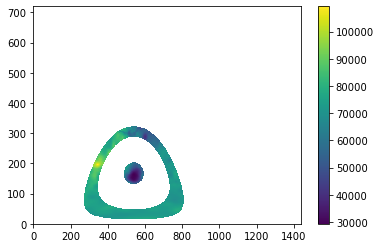

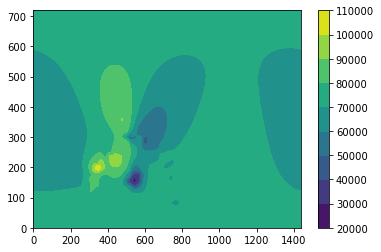

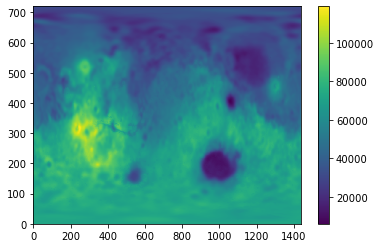

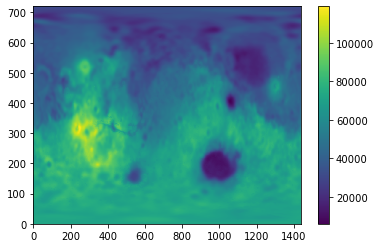

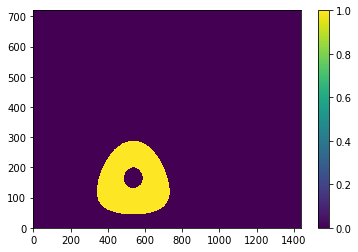

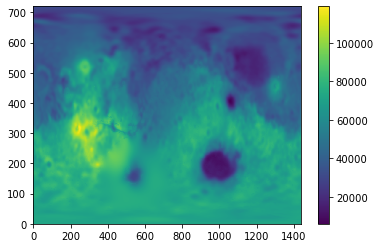

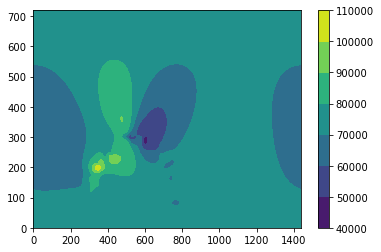

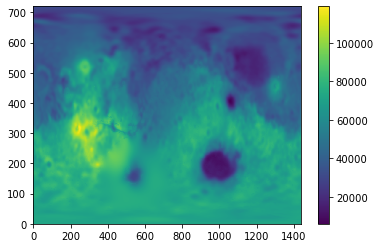

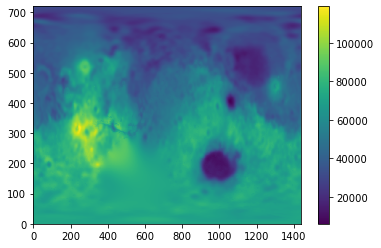

In [7]:
HM = np.loadtxt('grids/W19_l90.xyz')

sus = HM[:,2].reshape(720,1440)
sus = np.hstack((sus[:,720:],sus[:,:720]))

sus_in = sus.copy()
sus_orig = sus.copy()
sus_ramp = sus.copy()
sus_fill = sus.copy()



# smoothing case
sus[np.logical_and(CraterDistance.data<outer_limit,CraterDistance.data>inner_limit)] = np.nan

ind_hole = np.isnan(sus.flatten())
mskgrd = CraterDistance.copy()
mskgrd.data = np.logical_not(np.isnan(sus))
mskgrd.to_netcdf('tmpmask.nc')

sus[CraterDistance.data>outer_limit*1.25] = np.nan
#ind_outer_hole = np.isnan(sus.flatten())

plt.pcolormesh(sus)
plt.colorbar()
plt.show()

sus = interpolate_hole(lons, lats, sus, ind_hole, method='greenspline')

plt.pcolormesh(sus_ramp)
plt.colorbar()
plt.show()

sus_ramp[np.unravel_index(ind_hole.nonzero(), sus_ramp.shape)] = sus[np.unravel_index(ind_hole.nonzero(), sus.shape)]

plt.pcolormesh(sus_orig)
plt.colorbar()
plt.show()

plt.pcolormesh(ind_hole.reshape(sus_ramp.shape))
plt.colorbar()
plt.show()

plt.pcolormesh(sus_ramp)
plt.colorbar()
plt.show()

# filling case
sus = sus_orig.copy()
sus[CraterDistance.data<outer_limit] = np.nan

ind_hole = np.isnan(sus.flatten())
mskgrd = CraterDistance.copy()
mskgrd.data = np.logical_not(np.isnan(sus))
mskgrd.to_netcdf('tmpmask.nc')

sus[CraterDistance.data>outer_limit*1.25] = np.nan

sus = interpolate_hole(lons, lats, sus, ind_hole, method='greenspline')

sus_fill[np.unravel_index(ind_hole.nonzero(), sus.shape)] = sus[np.unravel_index(ind_hole.nonzero(), sus.shape)]

plt.pcolormesh(sus_ramp)
plt.colorbar()
plt.show()

plt.pcolormesh(sus_fill)
plt.colorbar()
plt.show()

In [8]:
print(sus_in.min())

#cthick_modified = sus_in * ramping

fmt = '%1.3f', '%1.3f', '%1.12f'
# Save to an ascii file
np.savetxt('grids/W19_l90_{:s}_removed_mincurv.xyz'.format(crater_name), np.vstack((lons.flatten(), 
                                lats.flatten(), 
                                sus_fill.flatten())).T, fmt=fmt)

# Save to an ascii file
np.savetxt('grids/W19_l90_{:s}_ramped_mincurv.xyz'.format(crater_name), np.vstack((lons.flatten(), 
                                lats.flatten(), 
                                sus_ramp.flatten())).T, fmt=fmt)


6077.672600974174


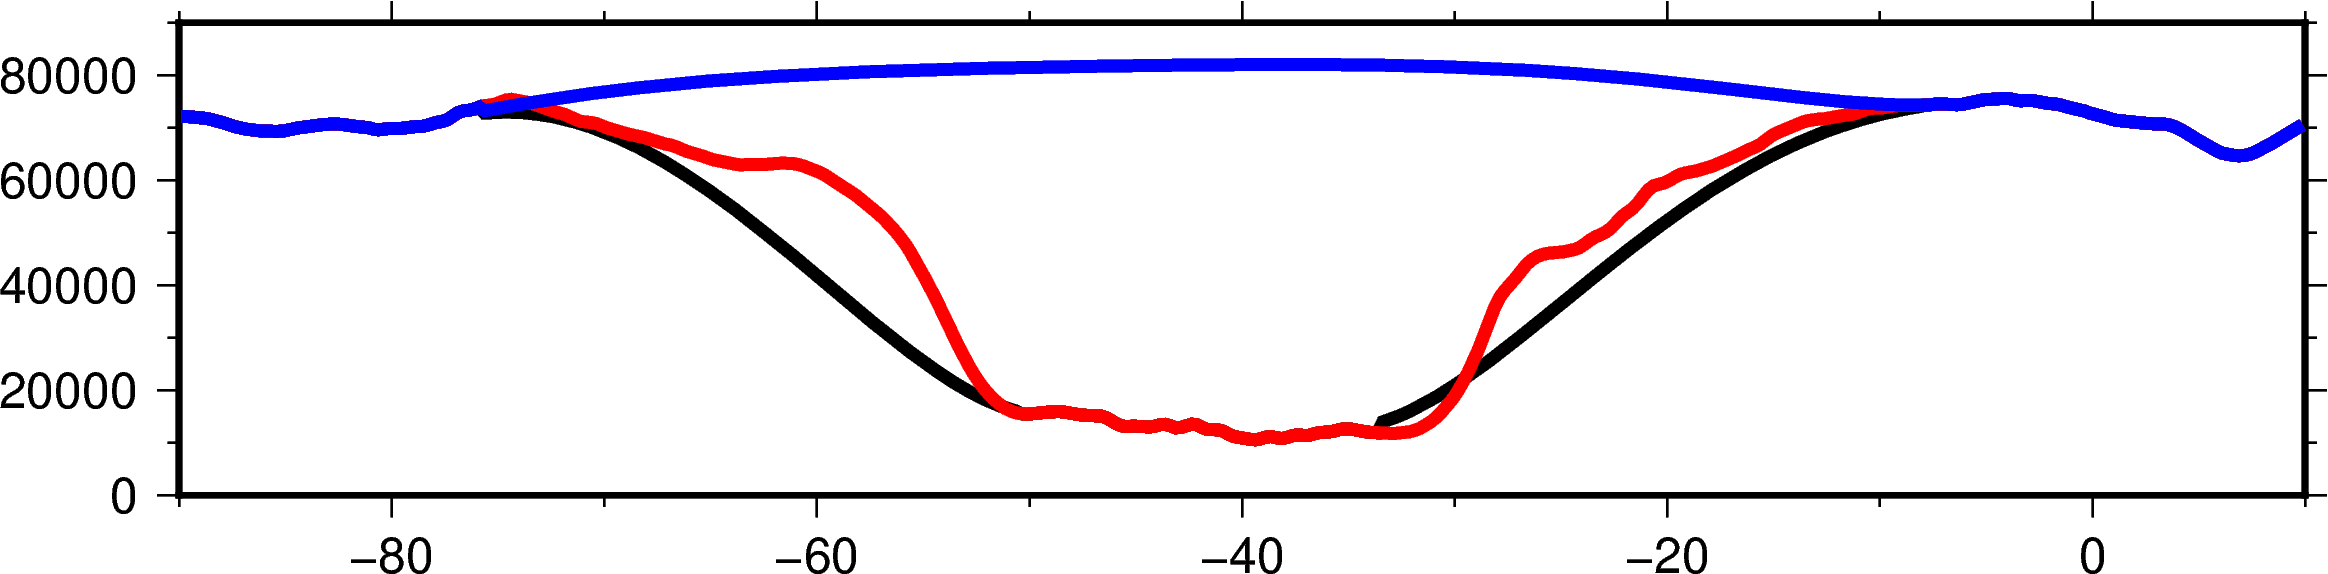

In [88]:
import pygmt

if crater_name=='Hellas':
    profile_longitude_index = 1000
    #profile_lat_min = 
elif crater_name=='Argyre':
    
elif crater_name=='Isidis':
    
fig = pygmt.Figure()
fig.basemap(region=[-90, 10, 0, 90000], projection="X18c/4c", frame=["af", "WSne"])
fig.plot(lats[0:400,profile_longitude_index], sus_ramp[0:400,profile_longitude_index], pen='3p,black')
fig.plot(lats[0:400,profile_longitude_index], sus_orig[0:400,profile_longitude_index], pen='3p,red')
fig.plot(lats[0:400,profile_longitude_index], sus_fill[0:400,profile_longitude_index], pen='3p,blue')
fig.show()